# 第 4章　神经网络的学习

主题是神经网络的学习，“学习”是指从训练数据中自动获取最优权重参数的过程。

我们会导入**损失函数**这一指标，找出尽可能小的损失函数的值


## 4.1 从数据中学习

“从数据中学习”，是指可以由数据自动决定权重参数的值。

### 4.1.1　数据驱动

在计算机视觉领域，常用的特征量包括SIFT、SURF和HOG，使用这些特征量将图像数据转换为向量，然后对转换后的向量使用机器学习中的SVM、KNN等分类器进行学习

与待处理的问题无关，神经网络可以将数据直接作为原始数据，进行“端对端”的学习

### 4.1.2　训练数据和测试数据

使用训练数据进行学习寻找最优的参数；使用测试数据评价训练得到的模型的实际能力。

为什么要分为训练数据和测试数据？**因为追求的是模型的泛化能力**

只对某个数据集过度拟合的状态称为**过拟合**

## 4.2 损失函数

### 4.2.1　均方误差

$$
E = \frac{1}{2} \sum_{k} (y_{k} - t_{k})^2
$$
这里，$y_k$是表示神经网络的输出，$t_k$表示监督数据(训练数据)，k表示数据的维数

In [1]:
from dis import show_code

#来实现这个均方误差
import numpy as np


def mean_squared_error(y, t):
    return 0.5 * np.sum((y - t) ** 2)


#设2为正确解
t = [0, 0, 1, 0, 0, 0, 0, 0, 0, 0]
#例子1：此时“2”的概率最高为0.6
y = [0.1, 0.05, 0.6, 0.0, 0.05, 0.1, 0.0, 0.1, 0.0, 0.0]
print(mean_squared_error(np.array(y), np.array(t)))
#例子2：此时“7”的概率最高为0.6
yy = [0.1, 0.05, 0.1, 0.0, 0.05, 0.1, 0.0, 0.6, 0.0, 0.0]
print(mean_squared_error(np.array(yy), np.array(t)))

0.09750000000000003
0.5975


**我们会发现，第一个例子的损失函数的值更小，和监督数据之间的误差较小，表明第一个例子的输出结果与监督数据更加吻合**

### 4.2.2　交叉熵误差

$$
E = - \sum_{k} t_{k} \log y_{k}
$$

In [2]:
#实现交叉熵误差
def cross_entropy_error(y, t):
    delta = 1e-7
    return -np.sum(t * np.log(y + delta))

#为什么要加上delta？因为当出现log0时，会变为无限大会导致后续计算无法进行。

In [3]:
t = [0, 0, 1, 0, 0, 0, 0, 0, 0, 0]
y = [0.1, 0.05, 0.6, 0.0, 0.05, 0.1, 0.0, 0.1, 0.0, 0.0]
print(cross_entropy_error(np.array(y), np.array(t)))

y2 = [0.1, 0.05, 0.1, 0.0, 0.05, 0.1, 0.0, 0.6, 0.0, 0.0]
print(cross_entropy_error(np.array(y2), np.array(t)))

0.510825457099338
2.302584092994546


### 4.2.3　mini-batch学习

前两个方法考虑的都是针对单个数据的损失函数，如果要求所有训练数据的损失函数的总和，以交叉熵误差为例，可以写成下面的式

$$
E = - \frac{1}{N} \sum_{n} \sum_{k} t_{nk} \log y_{nk}
$$

数据由$N$个，$t_{nk}$表示第n个数据的第k个元素的值

从60000个训练数据中随机选择100笔，再用这100笔数据进行学习。这种学习方式称为**mini-batch学习**

**在这之前，先来看一下用于读入MNIST数据集的代码**

In [4]:
import sys, os
import numpy as np
from dataset.mnist import load_mnist

sys.path.append(os.pardir)
#通过设定参数one_hot_label=True，可以得到one-hot表示（即仅正确解标签为1，其余为0的数据结构）
(x_train, t_train), (x_test, t_test) = load_mnist(normalize=True, one_hot_label=True)
print(x_train.shape)  # (60000, 784)
print(t_train.shape)  # (60000, 10)

(60000, 784)
(60000, 10)


**如何从训练数据随机抽取110笔数据？使用NumPy的np.random.choice()**

In [5]:
#从 x_train 的维度中获取训练集的总大小（即 60000），并存入 train_size 变量
train_size = x_train.shape[0]
#设置小批量（mini-batch）的大小,在每一步训练中随机抽取 10 个数据点
batch_size = 10
#从 0 到 train_size - 1（即 0 到 59999）的整数中,随机抽取 batch_size（即 10）个数字。
batch_mask = np.random.choice(train_size, batch_size)  #batch_mask是NumPy数组

x_batch = x_train[batch_mask]
t_batch = t_train[batch_mask]

In [6]:
np.random.choice(60000, 10)


array([46337, 34328, 18743, 40893, 59190, 16656, 54717, 48671, 40087,
        5420], dtype=int32)

### 4.2.4　mini-batch版交叉熵误差的实现

**来实现一个可以同时处理单个数据和批量数据（数据作为batch集中输入）两种情况的函数**

In [7]:
def cross_entropy_error(y, t):
    if y.ndim == 1:
        y = y.reshape(1, y.size)
        t = t.reshape(1, t.size)

    batch_size = y.shape[0]
    return -np.sum(t * np.log(y + 1e-7)) / batch_size

这里，$y$是神经网络的输出，t是训练数据，y维度是1时，就是求单个数据的交叉熵误差时，需要改变数据的形状。并且当输入为mini-batch时，要用batch的个数进行正规化，计算单个数据的平均交叉熵误差

**当训练数据是标签形式不是one-hot表示时，交叉熵误差代码实现如下：**

In [8]:
def cross_entropy_error2(y, t):
    if y.ndim == 1:
        t = t.reshape(1, t.size)
        y = y.reshape(1, y.size)
    batch_size = y.shape[0]
    return -np.sum(np.log(y[np.arange(batch_size), t] + 1e-7)) / batch_size


### 4.2.5　为何要设定损失函数

*在进行神经网络的学习时，不能将识别精度作为指标。因为如果以识别精度为指标，则参数的导数在绝大多数地方都会变为0*

![55](Figure4/425.png)

## 4.3数值微分

我们在这里会介绍梯度是什么，有什么性质？

### 4.3.1 导数

言简意赅，就是表示某个瞬间的变化量

**代码如下**

In [9]:
#先看不好的实现示例
def numerical_diff(f, x):
    h = 10e-50
    return (f(x + h) - f(x - h)) / h


'''
这样会产生舍入误差，所谓舍入误差是指因省略小数的精细部分的数值二造成最终的计算结果上的误差
'''


'\n这样会产生舍入误差，所谓舍入误差是指因省略小数的精细部分的数值二造成最终的计算结果上的误差\n'

**因此我们引入差分这一概念**

In [10]:
def numerical_diff(f, x):
    h = 1e-4
    return (f(x + h) - f(x - h)) / (2 * h)

### 4.3.2　数值微分的例子

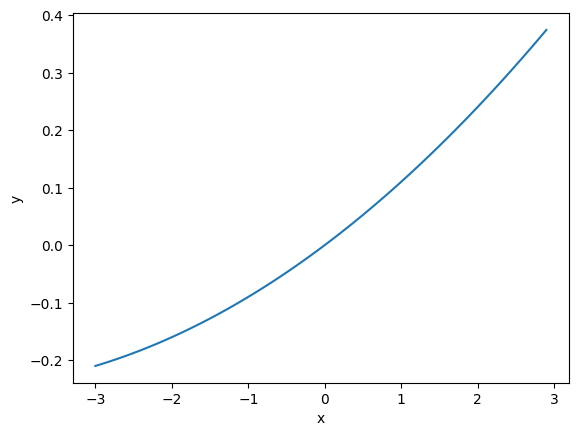

In [11]:
def funtion1(x):
    return 0.01 * x ** 2 + 0.1 * x


import numpy as np
import matplotlib.pyplot as plt

x = np.arange(-3.0, 3.0, 0.1)
y = funtion1(x)
plt.plot(x, y)
plt.xlabel('x')
plt.ylabel('y')
plt.show()

In [12]:
#计算x=0的导数
numerical_diff(funtion1, 0)

0.1

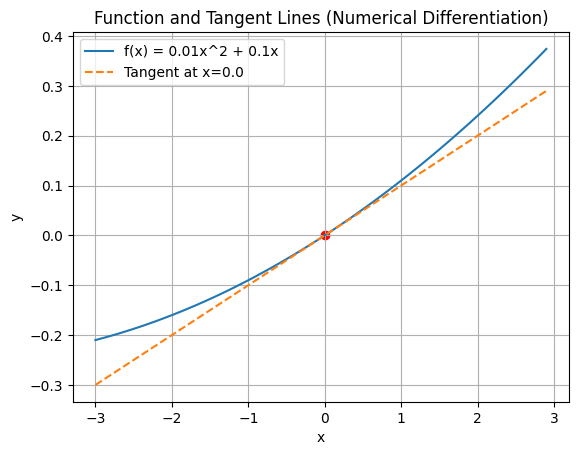

函数在 x=0 处的导数为: 0.1000


In [13]:
def funtion1(x):
    """
    定义的函数：y = 0.01 * x^2 + 0.1 * x
    """
    return 0.01 * x ** 2 + 0.1 * x


import numpy as np
import matplotlib.pyplot as plt


# 1. 定义数值微分函数（使用中心差分法）
def numerical_diff(f, x):
    """
    计算函数 f 在点 x 处的导数值。
    """
    h = 1e-4  # h 取一个极小值
    return (f(x + h) - f(x - h)) / (2 * h)


# 2. 定义切线函数
def tangent_line(f, x0):
    """
    返回在点 x0 处的切线函数。
    切线方程：y - y0 = a * (x - x0)
    """
    # 计算斜率 (a)
    a = numerical_diff(f, x0)
    # 计算切点处的 y 值 (y0)
    y0 = f(x0)

    # 返回切线方程的函数
    def line(x):
        return a * (x - x0) + y0

    return line


# 3. 绘图主程序
x = np.arange(-3.0, 3.0, 0.1)
y = funtion1(x)
# 计算 x=0 处的切线
x_target1 = 0.0
tan_f1 = tangent_line(funtion1, x_target1)
y_tan1 = tan_f1(x)

plt.plot(x, y, label='f(x) = 0.01x^2 + 0.1x')

# 绘制切线1 (x=0.0)
plt.plot(x, y_tan1, linestyle='--', label=f'Tangent at x={x_target1}')

# 标记切点
plt.scatter([x_target1], [funtion1(x_target1)], color='red', marker='o')

plt.xlabel('x')
plt.ylabel('y')
plt.title("Function and Tangent Lines (Numerical Differentiation)")
plt.legend()
plt.grid(True)
plt.show()

slope_at_0 = numerical_diff(funtion1, 0.0)
print(f"函数在 x=0 处的导数为: {slope_at_0:.4f}")


### 4.3.3偏导数

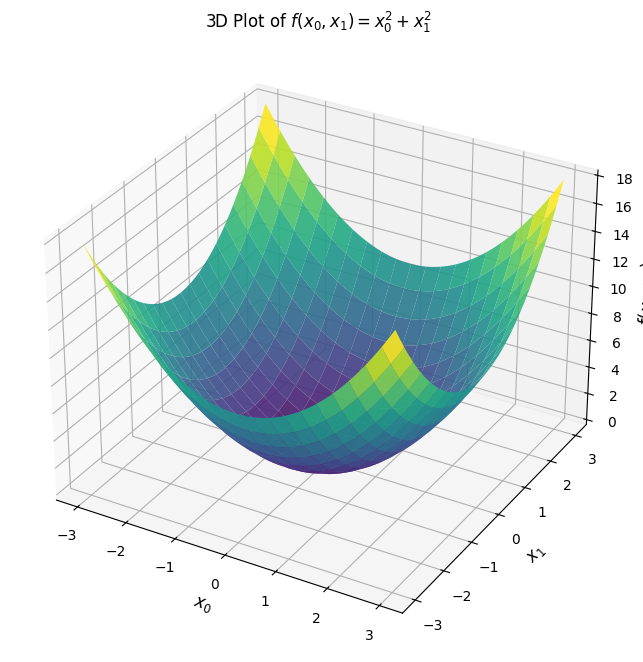

In [14]:
def function2(x0, x1):
    return x0 ** 2 + x1 ** 2
    #或者returnn np.sum(x**2)


from mpl_toolkits.mplot3d import Axes3D  # 导入 3D 绘图工具

# --- 1. 创建 x0 和 x1 的范围 ---
# 定义 x0 和 x1 的取值范围，例如从 -3 到 3
x0 = np.linspace(-3, 3, 100)
x1 = np.linspace(-3, 3, 100)

# --- 2. 创建网格数据 ---
# 使用 meshgrid 创建二维网格，用于计算每个点 (x0, x1) 上的函数值
X0, X1 = np.meshgrid(x0, x1)

# --- 3. 计算 Z 轴（函数输出）的值 ---
Z = function2(X0, X1)

# --- 4. 绘制 3D 表面图 ---
fig = plt.figure(figsize=(8, 8))
# 添加一个 3D 坐标轴
ax = fig.add_subplot(111, projection='3d')

# 绘制表面图
# cmap='viridis' 设置颜色映射
ax.plot_surface(X0, X1, Z, rstride=5, cstride=5, cmap='viridis', alpha=0.9)

# 设置标签和标题
ax.set_xlabel('$x_0$', fontsize=12)
ax.set_ylabel('$x_1$', fontsize=12)
ax.set_zlabel('f($x_0, x_1$)', fontsize=12)
ax.set_title('3D Plot of $f(x_0, x_1) = x_0^2 + x_1^2$')

# 显示图形
plt.show()

In [15]:
def function2(x):
    return x[0] ** 2 + x[1] ** 2

## 4.4梯度

全部变量的偏导数汇总而成的向量称为梯度

In [16]:
def numerical_gradient(f, x):
    h = 1e-4
    grad = np.zeros_like(x)
    for idx in range(x.size):
        tmp_val = x[idx]

        x[idx] = tmp_val + h
        fxh1 = f(x)
        x[idx] = tmp_val - h
        fxh2 = f(x)

        grad[idx] = (fxh1 - fxh2) / (2 * h)
        x[idx] = tmp_val  # 还原值
    return grad


numerical_gradient(function2, np.array([3.0, 4.0]))

array([6., 8.])

![99](Figure4/441.png)

梯度指示的方向
是各点处的函数值减小最多的方向

### 4.4.1　梯度法

寻找最小值的梯度法称为梯度下降法;寻找最大值的梯度法称为梯度上升法

$$
\begin{aligned}
x_0 &= x_0 - \eta \frac{\partial f}{\partial x_0} \\
x_1 &= x_1 - \eta \frac{\partial f}{\partial x_1}
\end{aligned}
$$

$\eta$表示学习率，学习率决定在一次学习中，应该学习多少， 以及在多大程度上更新参数

**我们来实现梯度下降法**

In [17]:
def gradient_descent(f, init_x, learning_rate=0.01, step_num=100):
    x = init_x
    for i in range(step_num):
        grad = numerical_gradient(f, x)
        x -= learning_rate * grad
    return x


init_x = np.array([-3.0, 4.0])
grad = gradient_descent(function2, init_x, learning_rate=0.1, step_num=100)
print(grad)

[-6.11110793e-10  8.14814391e-10]


需要注意一下，学习率过大的话会发散成一个很大的值；学习率过小的话，基本上没怎么更新就结束了

*像学习率这样的参数称为超参数。这是一种和神经网络的参数（权重
和偏置）性质不同的参数。相对于神经网络的权重参数是通过训练
数据和学习算法自动获得的，学习率这样的超参数则是人工设定的。
一般来说，超参数需要尝试多个值，以便找到一种可以使学习顺利
进行的设定*

### 4.4.2　神经网络的梯度

以一个简单的神经网络为例，来实现求梯度

In [18]:
import sys, os

sys.path.append(os.pardir)
import numpy as np
from common.functions import softmax, cross_entropy_error
from common.gradient import numerical_gradient


#softmax：将神经网络的输出转换为概率分布的函数
#cross_entropy_error：损失函数 交叉熵误差函数
#numerical_gradient：计算梯度


class simpleNet:
    ''''
    一个网络的类
    '''

    def __init__(self):
        #初始化网络的权重矩阵,表明输入层有两个神经元，输出层有三个神经元
        self.W = np.random.randn(2, 3)

    def predict(self, x):
        return np.dot(x, self.W)

    def loss(self, x, t):
        z = self.predict(x)
        y = softmax(z)
        loss = cross_entropy_error(y, t)
        return loss


net = simpleNet()
print(net.W)

x = np.array([0.6, 0.9])

p = net.predict(x)
print(p)
print(np.argmax(p))
t = np.array([0, 1, 1])
print(net.loss(x, t))

[[ 1.32008308 -0.19103396 -0.09787612]
 [-0.85012161 -0.29652439  0.91067665]]
[ 0.0269404  -0.38149233  0.76088331]
2
1.7296464715426387


**接下来求梯度**

In [19]:
def f(w):
    return net.loss(x, t)


dw = numerical_gradient(f, net.W)
print(dw)

[[ 0.16008658 -0.49359152  0.33350495]
 [ 0.24012987 -0.74038729  0.50025742]]


In [20]:
#另外，在上面的代码中，定义新函数时使用了“def f(x):···”的形式。实际上，Python中如果定义的是简单的函数，可以使用lambda表示法。使用lambda的情况下，上述代码可以如下实现:
f = lambda w: net.loss(x, t)
dw = numerical_gradient(f, net.W)


**求出神经网络的梯度后，接下来只需根据梯度法，更新权重参数即可**

## 4.5 学习算法的实现

神经网络存在合适的权重和偏置，调整权重和偏置以便拟合训练数据的过程称为“学习，总体来说，神经网络的学习分成下面四个步骤：

1.minibatch

从训练数据随机选出部分数据，部分数据就成为minibatch。我们的目标是减小minibatch的损失函数的值

2.计算梯度

如何减小minibatch损失函数的值？我们需要求出各个权重参数的梯度。梯度表示损失函数的值减小最多的方向。

3.更新参数

将权重参数沿梯度方向进行微小更新

4.重复

重复步骤1,2,3

*使用的数据是随机选择的mini batch数据，所以又称为随机梯度下降法*（对随机选择的数据进行的梯度下降法）【SGD】

**我们来实现手写数字识别的神经网络，以2层神经网络为对象（隐藏层位1层）**

### 4.5.1　2层神经网络的类

In [22]:
import sys, os

sys.path.append(os.pardir)
from common.functions import *
from common.gradient import numerical_gradient


class TwoLayerNet:
    def __init__(self, input_size, hidden_size, output_size, weight_init_std=0.01):
        #输入层的神经元数，隐藏层...，输出层...
        #初始化权重
        self.params = {}
        self.params['W1'] = weight_init_std * np.random.randn(input_size, hidden_size)
        self.params['W2'] = weight_init_std * np.random.randn(hidden_size, output_size)
        self.params['b1'] = np.zeros(hidden_size)
        self.params['b2'] = np.zeros(output_size)

    def predict(self, x):
        w1, w2 = self.params['W1'], self.params['W2']
        b1, b2 = self.params['b1'], self.params['b2']

        a1 = np.dot(x, w1) + b1
        z1 = sigmoid(a1)
        a2 = np.dot(z1, w2) + b2
        y = softmax(a2)
        return y

    #x：输入数据 t:训练数据
    def loss(self, x, t):
        y = self.predict(x)
        return cross_entropy_error(y, t)

    def accuracy(self, x, t):
        y = self.predict(x)
        y = np.argmax(y, axis=1)
        t = np.argmax(t, axis=1)
        accuracy = np.sum(y == t) / float(x.shape[0])
        return accuracy

    #x：输入数据 t:训练数据
    def numerical_gradient(self, x, t):
        loss_W = lambda W: self.loss(x, t)
        grads = {}
        grads['W1'] = numerical_gradient(loss_W, self.params['W1'])
        grads['W2'] = numerical_gradient(loss_W, self.params['W2'])
        grads['b1'] = numerical_gradient(loss_W, self.params['b1'])
        grads['b2'] = numerical_gradient(loss_W, self.params['b2'])
        return grads

In [26]:
net = TwoLayerNet(input_size=784, hidden_size=100, output_size=10)
net.params['W1'].shape# (784, 100)
net.params['W2'].shape# (100, 10)
net.params['b1'].shape # (100,)
net.params['b2'].shape# (10,)

(10,)

如何设置权重参数的初始值?

**权重使用符合高斯分布的随机数进行初始化，偏置使用0进行初始化**

### 4.5.2　mini-batch的实现

In [30]:
import numpy as np
from dataset.mnist import load_mnist

(x_train,t_train),(x_test,t_test)=load_mnist(normalize=True,one_hot_label=True)

train_loss_list = []
#超参数
iters_sum=10000
train_size = x_train.shape[0]
batch_size = 100
learning_rate = 0.1
network = TwoLayerNet(input_size=784, hidden_size=100, output_size=10)

for i in range(iters_sum):
    #获取minibatch
    batch_mask = np.random.choice(train_size, batch_size)
    x_batch = x_train[batch_mask]
    t_batch = t_train[batch_mask]

    #计算梯度
    grad = network.numerical_gradient(x_batch, t_batch)
    #grad = network.gradient(x_batch, t_batch)
    #更新参数
    for key in ('W1', 'b1', 'W2', 'b2'):
        network.params[key] -= learning_rate * grad[key]

    #记录学习过程
    loss = network.loss(x_batch, t_batch)
    train_loss_list.append(loss)


KeyboardInterrupt: 

### 4.5.3　基于测试数据的评价

**神经网络学习的最初目标是掌握泛化能力，因此，要评价神经网络的泛
化能力，就必须使用不包含在训练数据中的数据**